# Hydrocarbon Processing with cubic equation of state case study

## 1. Introduction

This Jupyter Notebook solves and optimizes a simple hydrocarbon processing unit. A property package has been created for hydrocarbon processing wivh includes methane, ethane, propane, n-butane, i-butane, ethylene, propene, butene, pentene, hexene, heptene and octene. Additionally, a sensitivity study is performed over the influence of temperature in the Gibbs reactor.

### 1.1 Tutorial objectives

The goals of this tutorial are:

* Utilize the heat exchanger, gibbs reactor and flash unit models.
* Utilize the Generic Property Package, which provides a flexible platform for users to build property packages by calling upon libraries of modular sub-models to build up complex property calculations with the least effort possible.
* Demonstrate the use of arcs as streams connecting unit models
* Save a jazon file to avoid initialization if it has been done before.
* Demonstrate the sequential initialization approach, including the use of the propagate_state method in idaes/core/util/initialization.
* Fix state variables for different conditions and initialize and solve the flowsheet for these conditions.
* Solve problem in order to:
    * Solve square problem
    * Minimize operating costs
* Create sensitivity analysis and create a plot from the results

## 2. Problem Statement

The flowsheet that we will be using for this module is shown below. We will be processing ethylene, propene and butene to produce pentene, hexene, heptene and octene. As shown in the flowsheet, there is a Gibbs reactor, R101, one flash tanks, F101 to separate out the non-condensibles. We will assume ideal gas for this flowsheet.

![](HC_processing.png)

The property package required for this module is available in the property example directory:

- HC_PR.py (for VLE calcullations)
- HC_PR_vap.py (for equipment that work only in vapor phase)

The state variables chosen for the property package are **flows of component by phase, temperature and pressure**. The components considered are: **methane, ethane, propane, n-butane, i-butane, ethylene, propene, butene, pentene, hexene, heptene and octene**. Therefore, every stream has 8 flow variables, 1 temperature and 1 pressure variable. 

In this example, we will simulate the following cases:

* Case 1: Solve square problem.
* Case 2: Minimize operating costs.
* Sensitivity Analysis 1: Temperature in the Gibbs reactor.

## 2.1 Setting up the problem in IDAES

In the next cell, we will be importing the necessary components from Pyomo and IDAES.

In [1]:
# Import objects from pyomo package
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import (Flash, GibbsReactor, Heater)

For this specific problem we will need two different property packages as we will utilize an only vapor property package for the Gibbs reactor and a VLE package for the flash column

In [2]:
# Import the HC_PR property package to create a VLE property block for the flowsheet
from idaes.generic_models.properties.core.examples.HC_PR import configuration

# Import the HC_PR_vap property package to create a vapor property block for the flowsheet
from idaes.generic_models.properties.core.examples.HC_PR_vap import configuration_vap

### 2.1 Building the flowsheet 

In the next cell, we will first create a model and attach a flowsheet to it. We then introduce the unit models and connect them through an arc and analyze the degrees of freedom of the flowsheet and how many variables we need to fix.

In [3]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.VLE_props = GenericParameterBlock(default=configuration)
m.fs.Vap_props = GenericParameterBlock(default=configuration_vap)

# Create an instance of the units, attaching them to the flowsheet
# Specify that the property package to be used with with eash unit.
m.fs.H101 = Heater(default={"property_package": m.fs.Vap_props,
                            "has_pressure_change": False,
                            "has_phase_equilibrium": True})
m.fs.R101 = GibbsReactor(
            default={"property_package": m.fs.Vap_props,
                     "inert_species":["hydrogen","methane","ethane","propane","nbutane"],
                     "has_heat_transfer": True})

m.fs.H102 = Heater(default={"property_package": m.fs.VLE_props,
                            "has_pressure_change": False,
                            "has_phase_equilibrium": True})

m.fs.F101 = Flash(default={"property_package": m.fs.VLE_props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Create streams to define connectivity between unit models
m.fs.s01 = Arc(source=m.fs.H101.outlet, destination=m.fs.R101.inlet)
m.fs.s02 = Arc(source=m.fs.R101.outlet, destination=m.fs.H102.inlet)
m.fs.s03 = Arc(source=m.fs.H102.outlet, destination=m.fs.F101.inlet)

# Expand arcs
TransformationFactory("network.expand_arcs").apply_to(m)

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 21


### 2.2 Create solver object 

In [4]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## 3 Case 1:Square problem.

For this tutorial, we will solve a series of case studies by changing the goal of the solution. For the first case we will solve a square problem where all equipment and stream conditions are fixed.

## 3.1 Fix initial conditions

The conditions were extracted from *Valorization of Shale Gas Condensate to Liquid Hydrocarbons through Catalytic Dehydrogenation and Oligomerization*, Taufik Ridha,Yiru Li,Emre GençerOrcID,Jeffrey J. Siirola,Jeffrey T. Miller,Fabio H. Ribeiro andRakesh Agrawal, 2018. 

In [5]:
# Fix Heater H101 inlet conditions
m.fs.H101.inlet.mole_frac_comp[0, "hydrogen"].fix(0.05)
m.fs.H101.inlet.mole_frac_comp[0, "methane"].fix(0.25)
m.fs.H101.inlet.mole_frac_comp[0, "ethane"].fix(0.2)
m.fs.H101.inlet.mole_frac_comp[0, "propane"].fix(0.025)
m.fs.H101.inlet.mole_frac_comp[0, "nbutane"].fix(0.05)
m.fs.H101.inlet.mole_frac_comp[0, "ibutane"].fix(0.05)
m.fs.H101.inlet.mole_frac_comp[0, "ethylene"].fix(0.13)
m.fs.H101.inlet.mole_frac_comp[0, "propene"].fix(0.13)
m.fs.H101.inlet.mole_frac_comp[0, "butene"].fix(0.115)
m.fs.H101.inlet.mole_frac_comp[0, "pentene"].fix(0.0)
m.fs.H101.inlet.mole_frac_comp[0, "hexene"].fix(0.0)
m.fs.H101.inlet.mole_frac_comp[0, "heptene"].fix(0.0)
m.fs.H101.inlet.mole_frac_comp[0, "octene"].fix(0.0)
m.fs.H101.inlet.flow_mol[0].fix(100)
m.fs.H101.inlet.temperature.fix(1073)
m.fs.H101.inlet.pressure.fix(550000)

# Fix unit models operating conditions
# Fix H101 Heater outlet temperature
m.fs.H101.outlet.temperature.fix(573)

# Fix R101 Reactor outlet temperature
m.fs.R101.outlet.temperature[0].fix(573)

# Fix H102 Heater outlet temperature
m.fs.H102.outlet.temperature.fix(300)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300.0)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [6]:
assert DOF_final == 0

### 3.2 Flowsheet Initialization

IDAES includes pre-written initialization routines for all unit models. The output from initialization can be set to 7 different levels depending on the details required by the user. In general, when a particular output level is set, any information at that level and above gets picked up by logger. The default level taken by the logger is INFO. More information on these levels can be found in the IDAES documentation: https://idaes-pse.readthedocs.io/en/latest/logging.html

In [7]:
seq = SequentialDecomposition()
seq.options.select_tear_method = "heuristic"
seq.options.tear_method = "Wegstein"
seq.options.iterLim = 5

# Using the SD tool
G = seq.create_graph(m)
heuristic_tear_set = seq.tear_set_arcs(G, method="heuristic")
order = seq.calculation_order(G)

for o in heuristic_tear_set:
    print(o.name)
print("Order of initialization")
for o in order:
    print(o[0].name)    
    
def function(unit):
        unit.initialize(outlvl=idaeslog.INFO_HIGH)  

Order of initialization
fs.H101
fs.R101
fs.H102
fs.F101


### 3.3 Saving a jazon file 

In the next cell we will save a jazon file to avoid initialization if it has been done before.

In [8]:
# Import python path
import os

# Import idaes model seralizer to store initialized model
from idaes.core.util import model_serializer as ms 

In [9]:
if not os.path.exists("HI_init.json.gz"):
    seq.run(m, function)
    
    # Solve the simulation using ipopt
    # Note: If the degrees of freedom = 0, we have a square problem
    solve_status = solver.solve(m, tee=True)

    ms.to_json(m, fname="HI_init.json.gz")
else:
    ms.from_json(m, fname="HI_init.json.gz")

### 3.3 Run Simulation

In [10]:
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [11]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### 3.4 Results

In [12]:
# Display output report
m.fs.H101.report()
m.fs.R101.report()
m.fs.H102.report()
m.fs.F101.report()


Unit : fs.H101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value       : Fixed : Bounds
    Heat Duty : -6.0523e+06 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                    Inlet     Outlet  
    Total Molar Flowrate             100.00     100.00
    Total Mole Fraction hydrogen   0.050000   0.050000
    Total Mole Fraction methane     0.25000    0.25000
    Total Mole Fraction ethane      0.20000    0.20000
    Total Mole Fraction propane    0.025000   0.025000
    Total Mole Fraction nbutane    0.050000   0.050000
    Total Mole Fraction ibutane    0.050000   0.050000
    Total Mole Fraction ethylene    0.13000    0.13000
    Total Mole Fraction propene     0.13000    0.13000
    Total Mole Fraction butene      0.115

As we can see from solving the square problem the Flash has a Heat Duty = 0, we have a liquid outlet of 10.99 and a vapor as expected.

## 4. Case 2: Minimize operating costs.

### 4.0 Create purity and flow parameters

We will inttroduce two new parameters one for purity and liquid flow from the Flash column.

In [ ]:
m.fs.Pur = Param(mutable=True,default=0.040)
m.fs.Liq = Param(mutable=True,default=10)

### 4.1 Create constraints

We will create constraints to set the inlet and outlet reactor temperature. And expressions to calculate costs.

In [16]:
# Set constraint over the inlet and outlet of the temperature of the reactor
m.fs.reactorT = Constraint(expr=m.fs.H101.outlet.temperature[0] == 
                    m.fs.R101.outlet.temperature[0])

# Set constraint over the purity of the octene after the flash
m.fs.purity = Expression(
        expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "octene"])
m.fs.product_purity = Constraint(expr=m.fs.purity >= m.fs.Pur)

# Set constraint over the minimum amount of liquid in the flas outlet
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.flow_mol[0]>= m.fs.Liq)

# Set expressions to calculate 
m.fs.cooling_cost = Expression(expr=0.212e-7 * ((-m.fs.H101.heat_duty[0]) +
                                  (-(m.fs.R101.heat_duty[0])) +
                                    (-m.fs.H102.heat_duty[0])))

m.fs.heating_cost = Expression(expr=2.2e-7 * ((m.fs.F101.heat_duty[0]**2)**1/2))

m.fs.operating_cost = Expression(expr=(3600 * (m.fs.heating_cost +
                                            m.fs.cooling_cost)))

m.fs.objective = Objective(expr=m.fs.operating_cost)

### 4.2 Unfix operation conditions

In the next cell we will unfix the conditions we want want the problem to optimize.

In [17]:
# Unfix operation condition
m.fs.H101.outlet.temperature.unfix()
m.fs.R101.heat_duty.unfix()
m.fs.R101.outlet.temperature.unfix()
m.fs.F101.vap_outlet.temperature.unfix()
m.fs.F101.deltaP.unfix()

# Set bounds on unit model operating conditions
m.fs.H101.outlet.temperature[0].setlb(350)
m.fs.H101.outlet.temperature[0].setub(800)

m.fs.R101.outlet.temperature[0].setlb(350)
m.fs.R101.outlet.temperature[0].setub(800)

m.fs.F101.vap_outlet.temperature[0].setlb(298.0)
m.fs.F101.vap_outlet.temperature[0].setub(450.0)
m.fs.F101.vap_outlet.pressure[0].setlb(105000)
m.fs.F101.vap_outlet.pressure[0].setub(550000)

### 4.3 Run Simulation

In [18]:
results = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

### 4.4 Results

In [19]:
print('operating cost = $', value(m.fs.operating_cost))

print()
print('Product flow rate and purity in F102')

m.fs.F101.report()

print()
print('octene purity = ', value(m.fs.purity))

operating cost = $ 727.2698569414957

Product flow rate and purity in F102

Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value     : Fixed : Bounds
          Heat Duty : -0.010422 : False : (None, None)
    Pressure Change :   -27512. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                               Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                    88.047       78.047        10.000  
    mole_frac_comp hydrogen   0.056788     0.064064    1.0000e-08  
    mole_frac_comp methane     0.28394      0.32032    1.0000e-08  
    mole_frac_comp ethane      0.22715      0.25092      0.041664  
    mole_frac_comp propane    0.028394     0.029858      0.016967  
    mole_frac_comp nbutane    0.056788     0.

As we can see from the Flash report we optimized the reactor conditions however we are limited by the octene purity and the amount of the liquid flow at the end of the flash column.

## 5. Sensitivity Analysis

### 5.0 Building sensitivity analysis

In [22]:
purity = np.linspace(0.010, 0.065, 3)
liq = np.linspace(5, 12, 3)
vap_flow = np.zeros((len(purity),len(liq))) 
vap_T = np.zeros((len(purity),len(liq))) 
vap_P = np.zeros((len(purity),len(liq))) 
reactor_temp = np.zeros((len(purity),len(liq))) 
cost = np.zeros((len(purity),len(liq))) 

for j in range(len(purity)):
    m.fs.Pur = purity[j]
 
    for k in range(len(liq)):       
        m.fs.Liq = liq[k]
        # solve the model
        status = solver.solve(m)

        vap_flow[j,k]= (value(m.fs.F101.vap_outlet.flow_mol[0]))
        vap_T[j,k]= (value(m.fs.F101.vap_outlet.temperature[0]))
        vap_P[j,k]= (value(m.fs.F101.vap_outlet.pressure[0]))
        cost[j,k]= (value(m.fs.operating_cost))
        reactor_temp[j,k]= (value(m.fs.R101.outlet.temperature[0]))

### 5.1 Plot reactor temperature results

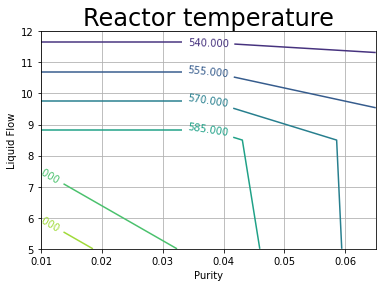

In [23]:
fig, ax = plt.subplots()
                  
CS = ax.contour(purity, liq, reactor_temp)
                  
ax.clabel(CS, inline=1, fontsize=10)

plt.grid()
plt.title("Reactor temperature",fontsize=24)
plt.xlabel("Purity")
plt.ylabel("Liquid Flow")

plt.show()

### 5.2 Plot cost results

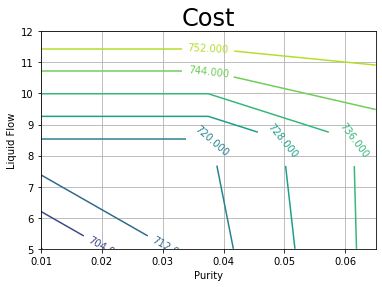

In [24]:
fig, ax = plt.subplots()
                  
CS = ax.contour(purity, liq, cost)
                  
ax.clabel(CS, inline=1, fontsize=10)

plt.grid()
plt.title("Cost",fontsize=24)
plt.xlabel("Purity")
plt.ylabel("Liquid Flow")

plt.show()

From the plots we can see that to increase the liquid flow and purity you require to increase the reactor temperature which will increase the cost of the process.